# Setup env

In [1]:
### All imports
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path

current_dir = Path(os.getcwd()).parent  # Get current dir (.parent, for root dir).

In [2]:
# Load the current state of the dataset into a df
data_dir = current_dir / "datasets" / "preprocessing"
data_path = data_dir / "english_lang.csv"
all_data_df = pd.read_csv(data_path)
all_data_df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)# Droping some cols (due to a bug in dataset creation)

all_data_df.head()

,text,word_count
0,April (Apr.) is the fourth month of the year i...,31
1,April always begins on the same day of the wee...,30
2,"April comes between March and May, making it t...",40
3,April begins on the same day of the week as Ju...,51
4,"In common years, April starts on the same day ...",103


# Data preparation

## Data splits

### Create splits

In [3]:
### Split the data into train-test-validation splits
def get_splits(target_data: list,
               train_size: float = 0.7,
               test_size: float = 0.15,
               validation_size: float = 0.15,
               shuffle: bool = True,
               seed: int = None) -> tuple:
    """
    Splits target_data into train-val-test datasets.
    
    Args:
        target_data: dataset to split on
        train_size: size of the train dataset
        test_size: size of the test dataset
        validation_size: size of the validation dataset
        shuffle: shuffle the target_dataset before spliting
        seed: control randomness in shuffle (default = None)
    Returns:
        train_split, test_split, validation_split
    """
    _total = train_size+test_size+validation_size
    assert _total == 1, f"Total size must be 1 (100%), got: {_total} ({_total*100}%)"
    import random

    # Setup
    _sum = train_size+test_size+validation_size
    assert _sum == 1, f"Sum of all sizes must be 1 got {sum}"
    if seed is not None:
        random.seed(seed)
    if shuffle:
        random.shuffle(target_data)

    # Get split idx's
    total_length = len(target_data)
    train_end_idx = int(total_length * train_size)
    test_end_idx = train_end_idx + int(total_length * test_size) + 1
    validation_end_idx = test_end_idx + int(total_length * validation_size) + 1

    # Split the data into train-test-validation
    train_split = target_data[:train_end_idx]
    test_split = target_data[train_end_idx:test_end_idx]
    validation_split = target_data[test_end_idx:validation_end_idx]

    return train_split, test_split, validation_split

def validate_splits(train_data: list,
                    test_data: list,
                    validation_data: list,
                    leak_ok: bool = False) -> tuple:
    """
    Validates the datasplits by counting the number of overlapping/shared samples between datasets.
    
    Args:
        leak_ok: set to False to check for data-leakage, set to True otherwise
        *All other arguments have same meaning as their name
    Returns:
        samples that overlap
    """
    
    _train_set = set(train_data)
    _test_set = set(test_data)
    _validation_set = set(validation_data)
    
    overlap_train_test = _train_set.intersection(_test_set)
    overlap_train_validation = _train_set.intersection(_validation_set)
    overlap_validation_test = _validation_set.intersection(_test_set)
    
    print(f"Overlap train-test: {len(overlap_train_test)}")
    print(f"Overlap train-validation: {len(overlap_train_validation)}")
    print(f"Overlap validation-test: {len(overlap_validation_test)}")
    
    _sum = len(overlap_train_test)+len(overlap_train_validation)+len(overlap_validation_test)
    
    if leak_ok == False and _sum > 0:
        print(f"[!!!CRITICAL!!!] There exists a data-leakage. Found '{_sum}' samples overlaping.")
    
    return overlap_train_test, overlap_train_validation, overlap_validation_test


In [4]:
# Store all lines from df into arr
all_data_list = all_data_df["text"].tolist()

# Get splits
train_data, test_data, validation_data = get_splits(
    target_data=all_data_list,
    seed=42
    # Leaving all as default
)

# Get some info about the splits
_sum = len(train_data)+len(test_data)+len(validation_data)  # sum of splits
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Validation samples: {len(validation_data)}")
print(f"{_sum==len(all_data_list)}")

# Check for data leakages
overlaps = validate_splits(
    train_data=train_data,
    test_data=test_data,
    validation_data=validation_data,
    leak_ok=False,  # We may have some leaks atm from chars like "\n"
)


Train samples: 556689
Test samples: 119291
Validation samples: 119291
True
Overlap train-test: 1661
Overlap train-validation: 1683
Overlap validation-test: 665
[!!!CRITICAL!!!] There exists a data-leakage. Found '4009' samples overlaping.


In [5]:
### Understanding the overlaping texts
# Get overlap counts
print(f"Train-test: {len(overlaps[0])} | Train-val: {len(overlaps[1])} | Val-test: {len(overlaps[2])}")

# Checking the overlaps
train_val_overlaps_df = pd.DataFrame(data=overlaps[1], columns=["text"])
train_val_overlaps_df.head()

Train-test: 1661 | Train-val: 1683 | Val-test: 665


,text
0,<section begin=qf3 /><section end=qf3 />\n
1,A wave is a kind of oscillation (disturbance) ...
2,319||100\n
3,7||0||3||0||0||0||10||0\n
4,14||0\n


I think the issue is caused with my implementation of the `get_splits` function, so ill try to verify it using the **train-test split** function from **sklearn**.\
Though "my" implementation shouldn't cause any problems (from a logical perspective), lets just verify for the samke of it.

In [6]:
from sklearn.model_selection import train_test_split

# Split for train_data
train_data, test_data = train_test_split(all_data_list, train_size=0.7, test_size=0.3, random_state=42)
# Split for val and test
validation_data, test_data = train_test_split(test_data, train_size=0.5, random_state=42)

overlaps = validate_splits(
    train_data=train_data,
    test_data=test_data,
    validation_data=[],
)

Overlap train-test: 1754
Overlap train-validation: 0
Overlap validation-test: 0
[!!!CRITICAL!!!] There exists a data-leakage. Found '1754' samples overlaping.


So... looks like there are some samples that are leaking b/w the train-val-test datasets.\
The validate splits function isn't a problem here, as it just compares the "set" of all values from its args. I.e. there exists some kind of overlaping samples.

### Analyse splits

Since the train-test-split function from sklearn resulted in a smaller number of overlaps, let use that as out reference to analyse the overlaping samples.

*This has little to do with the way sklearn splits the data, its due to the way we have to use it to split the data into train, _ first then split _ into test and val. (couldn't think of a good var name for _)*

In [7]:
### Analysis

# Covert overlaps from tuple to a dict of df's
if type(overlaps) == tuple:
    overlaps = {
        "train_val": pd.DataFrame(overlaps[0], columns=["text"]),
        "train_test": pd.DataFrame(overlaps[1], columns=["text"]),
        "val_test": pd.DataFrame(overlaps[2], columns=["text"]),
    }

# View few overlaping samples
print(overlaps["train_val"].head(10))

                                                text
0         <section begin=qf3 /><section end=qf3 />\n
1  In medicine "epidemiology" is the study of wha...
2                                         319||100\n
3  Scientists say this frog is related to the bla...
4                    139||8||13||2||23||1||175||11\n
5                                          524||33\n
6                                            14||0\n
7                             National Film Awards\n
8                                      Southampton\n
9                       Most people speak Finnish.\n


In [8]:
### Check number of occurences of samples in all_data_df

# Check sample overlap
overlaping_text = overlaps["train_val"].loc[1]["text"]
matches = all_data_df["text"] == overlaping_text

# Check number of overlaps
count_matches = matches.sum() if isinstance(matches, pd.Series) else sum(matches)
print(f"Occurrences: {count_matches}")

# Get idx of overlap entry to understand context
matches[matches].index

Occurrences: 2


Index([39947, 201048], dtype='int64')

In [9]:
for i in range(524911-3, 524911+3):
    print(all_data_df.loc[i]["text"])
print("---"*5)
for i in range(524913-3, 524913+3):
    print(all_data_df.loc[i]["text"])
print("---"*5)
for i in range(525016-3, 525016+3):
    print(all_data_df.loc[i]["text"])
print("---"*5)
for i in range(525021-3, 525021+3):
    print(all_data_df.loc[i]["text"])

1729 = 7*247, further check if 247 is a prime or not , if its not prime, continue the same steps of prime factorization for 247.

1729 = 7*247 = 7*13*19, Notice that all the factors for the 1729 at this point are prime and no further factors are possible except 1, so further factorization should be stopped.

"Encore une fois" is a 1997 song by the German DJ group Sash! and it features German singer Sabine Ohmes. It is the second single from Sash!'s first studio album "It's My Life – The Album" which was released on 25 August 1997.

It was played a lot in clubs around the world and is one of Sash!'s biggest songs.

"Ecuador" is a 1997 song by the German DJ group Sash! and it features German DJ Adrian Rodriguez. It is the third single from Sash!'s first studio album "It's My Life – The Album" which was released on 25 August 1997.

It was played a lot in clubs around the world and is one of Sash!'s biggest songs.

---------------
"Encore une fois" is a 1997 song by the German DJ group Sas

---

This shows that there are many places where the entries are repeating. This can be a problem with the dataset, or the way the data lines were split. But for now, since the samples are repeating around areas with similar context. We can drop the repeating samples.
So the next step would be to clean the data again from repeating samples.

---

In [10]:
### Getting rid of all repeating samples in the dataset
unique_df = all_data_df.drop_duplicates(subset="text", keep="first",)
len_unique_df = len(unique_df)
unique_df.reset_index(drop=True, inplace=True)
print(f"Number of samples droped: {len(all_data_df) - len_unique_df}")

unique_df.head(7)

Number of samples droped: 13511


,text,word_count
0,April (Apr.) is the fourth month of the year i...,31
1,April always begins on the same day of the wee...,30
2,"April comes between March and May, making it t...",40
3,April begins on the same day of the week as Ju...,51
4,"In common years, April starts on the same day ...",103
5,"In years immediately before common years, Apri...",70
6,April is a spring month in the Northern Hemisp...,30


In [11]:
### Saving this df as a '.csv'
save_path = data_dir / "unique_samples.csv"
unique_df.to_csv(save_path)
print(f"[INFO] Saved to: {save_path}")

[INFO] Saved to: /Users/dhruvnandigam/Desktop/Dhruv/Programing/NN/Inqueropedia/datasets/preprocessing/unique_samples.csv


### Final splits

In [35]:
# Create splits
unique_list = unique_df["text"].tolist()
train_data, test_data, validation_data = get_splits(
    target_data=unique_list,
    train_size=0.7,
    test_size=0.15,
    validation_size=0.15,
    shuffle=True,
    seed=42,
)

# Validate splits
overlaps = validate_splits(
    train_data=train_data,
    test_data=test_data,
    validation_data=validation_data,
    leak_ok=False
)


Overlap train-test: 0
Overlap train-validation: 0
Overlap validation-test: 0


In [37]:
len(train_data), len(validation_data), len(test_data)

(547232, 117263, 117265)

## Model preprocessing

### Data prep

Creating the **Tokenizer** and **Text-dataset** classes. \
These will be used to create PyTorch friendly datasets.

In [38]:
### Create a general purpose tokenizer
class Tokenizer():
    def __init__(self, token_size):
        """
        Creates an instance of a tokenizer.
        You can use this object to convert raw data into tokens.

        Args:
            token_size: size of each token
        """
        self.token_size = token_size
        self._vocab = None
        self._stoi = None
        self._itos = None

    def _preprocess(self,
                    text: list,
                    strip_punctuation = False) -> list:
        """
        Preprocesses a string to handle punctuation and normalize tokens.

        Args:
            text: a string to preprocess
            strip_punctuation: whether to strip punctuation during preprocessing
        Returns:
            Preprocessed string
        """
        import re
        import string

        # Strip punctuation if required
        if strip_punctuation:
            text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
        else:
            # Add spaces around punctuation
            text = re.sub(r"([.,!?;:])", r" \1 ", text)
            text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
        return text

    def _token_split(self,
                     text: str,
                     strip_punctuation) -> list:
        """
        Tokenize a single input string into chunks of token_size words.

        Args:
            text: a string to tokenize
            strip_punctuation: whether to strip punctuation during preprocessing
        Returns:
            A list, where each entry has 'token_size' number of words
        """
        tokens = []
        # Preprocess the string
        text = self._preprocess(text=text, strip_punctuation=strip_punctuation)
        words = text.split()
        for i in range(0, len(words), self.token_size):
            tokens.append(" ".join(words[i:i + self.token_size]))

        return tokens

    def build_vocab(self,
                   data: list,
                   strip_punctuation: bool = False):
        """
        Produces a vocab list, on the given tokens.

        Args:
            data: list of sentences to build the vocab on
            strip_puntuation: where to srip punctuation during preprocessing
        Returns:
             vocab: list of unique tokens
             stoi: dict mapping strings to indices
             itos: dict mapping indices to strings
        """
        tokens = []
        for sentence in data:
            tokens.extend(self._token_split(sentence, strip_punctuation=strip_punctuation))
        self._vocab = sorted(set(tokens))
        self._stoi = {token: idx for idx, token in enumerate(self._vocab)}
        self._itos = {idx: token for token, idx in self._stoi.items()}

        return self._vocab, self._stoi, self._itos

    def tokenize_string(self,
                 text: str,
                 strip_punctuation = False) -> list:
        """
        Tokenizes the given string into tokens based on the prebuilt vocab.

        Args:
            text: string to tokenize
            strip_puntuation: where to srip punctuation during preprocessing
        Returns:
            List of tokens converted to indices
        """
        assert self._stoi is not None, f"Vocab is not built yet. Call .build_vocab first."
        tokens = self._token_split(text=text, strip_punctuation=strip_punctuation)
        token_indices = [self._stoi[token] for token in tokens if token in self._stoi]

        return token_indices


In [57]:
### Create a "torch" friendly dataset
from torch.utils.data import Dataset, DataLoader
class TextDataset(Dataset):
    def __init__(self,
                 data,
                 tokenizer,
                 strip_punctuation = False,
                 max_len = None):
        """
        Custom dataset for tokenized text.
        Builds a tokenized dataset on provided data, using the specified tokenizer.

        Args:
            data: list of sentences
            tokenizer: instance of the Tokenizer class
            strip_punctuation: whether to strip punctuation during preprocessing.
            max_len: optional, maximum length of tokenized sequences (for padding).
        """
        self.data = data
        self.tokenizer = tokenizer
        self.strip_punctuation = strip_punctuation
        self.max_len = max_len
        self.tokenized_data = [self.tokenizer.tokenize_string(line, strip_punctuation) for line in self.data]
        if self.max_len:
            self.tokenized_data = [tokens[:self.max_len] for tokens in self.tokenized_data] # Truncate

    def __len__(self):
        """
        Number of samples in "data"
        """
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        """
        Returns a tokenized sample from "data" at "idx".

        Args:
            idx: index of sample to retrieve
        Returns:
            Sample at "idx", tokenized.
        """
        tokens = self.tokenized_data[idx]
        tokens_tensor = torch.tensor(tokens, dtype=torch.long)
        return tokens_tensor


In [40]:
### Tokenizer hyperparams
TOKEN_SIZE = 1
STRIP_PUNCTUATION = False

# Tokenizer instance (and setup)
tokenizer = Tokenizer(TOKEN_SIZE)
vocab, stoi, itos = tokenizer.build_vocab(
    data=train_data,
    strip_punctuation=STRIP_PUNCTUATION,
)


In [42]:
# Sample text data/strings
sample_data = [
    "This is the first sentence.",
    "Another example, with punctuation!",
    "Let's see if this works well."
]

"""
# Tokenize sample_data
sample_data_tokenized = tokenizer.tokenize_string(text=sample_data[0])
print(sample_data_tokenized)
for i in sample_data_tokenized:
    print(itos[i])
"""

dataset = TextDataset(data=sample_data, tokenizer=tokenizer, strip_punctuation=False, max_len=None)

In [43]:
dataset.__len__()

3

In [55]:
# Print the 'tokenized' form of a sentence, and convert it back into its 'string' form
print(f"Tokens: {dataset.__getitem__(1)}")
print(f"String: {' '.join(itos[i.item()] for i in dataset.__getitem__(1))}")

Tokens: tensor([158247, 509836, 119183, 605606, 566985,      0])
String: Another example , with punctuation !


In [57]:
len(itos)

619100

### Understanding the data

Why running analytics on the train data now?\
Well, its not a good idea to be 'aware' of any kinds of distibutions of the full dataset. This may lead to some bias in the way the model is designed and approached.\
In most cases we have access to the train (and) validation data, so that what we will be access at this juncture.

From now on, the word_count distribution, outliers, etc will be done on the training data only.\
The val and test datasets will be during this proces.

In [16]:
# Check d-type
print(f"Train data type: {type(train_data)}")

# Training data dataframe
train_data_df = pd.DataFrame(data=train_data, columns=["text"])
train_data_df["word_count"] = train_data_df["text"].apply(lambda x: len(str(x).split()))

# Verify train_data_df init
train_data_df.head()

Train data type: <class 'list'>


,text,word_count
0,Niederfüllbach is a municipality in the distri...,13
1,Multiplication is a bit different:\n,5
2,"Irvin Lee Baxter Jr. (July 8, 1945 – November ...",44
3,When the client reports no distress related to...,54
4,"The third part of the ramjet is the combustor,...",110


In [50]:
### Understanding word_count | will use this to set up an effective context_size (block_size)
word_counts = train_data_df["word_count"].to_numpy()
word_counts.sort(axis=0)

# Mean
mean = np.mean(word_counts)
print(f"Mean: {mean:.2f}")

# Standard deviation
std = word_counts.std()
print(f"Standard deviation: {std:.2f}")

# Median
print(f"Median: {np.median(word_counts)}")

# 90th percentile word_count
context_size = np.percentile(a=word_counts, q=95)
print(f"90th percentile: {context_size}")


Mean: 36.85
Standard deviation: 33.68
Median: 29.0
90th percentile: 100.0


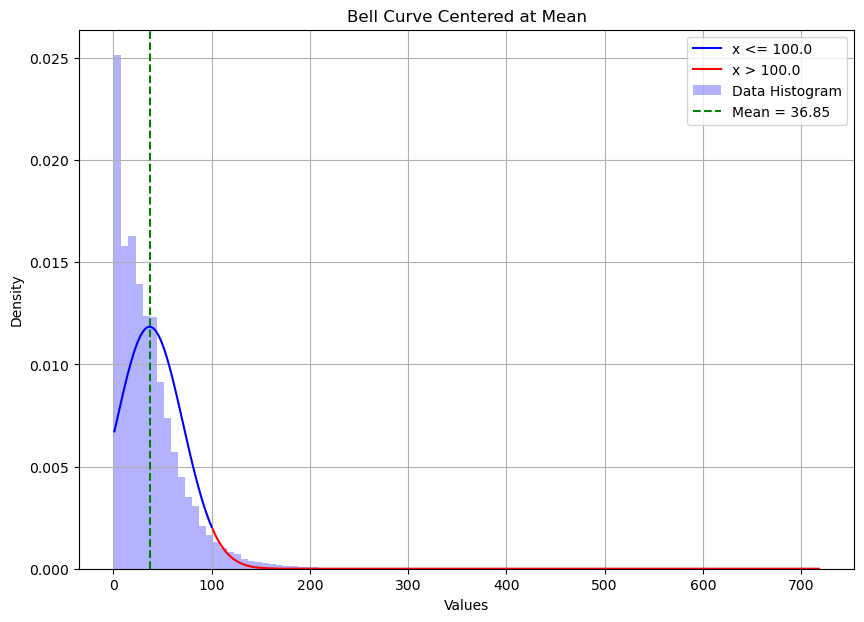

In [56]:
x = word_counts
y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((word_counts - mean) / std)**2)

x_below = x[x <= context_size]
y_below = y[x <= context_size]

x_above = x[x > context_size]
y_above = y[x > context_size]



plt.figure(figsize=(10, 7))

plt.plot(x_below, y_below, color='blue', label=f"x <= {context_size}")
plt.plot(x_above, y_above, color='red', label=f"x > {context_size}")

plt.hist(word_counts, bins=100, density=True, alpha=0.3, color='blue', label='Data Histogram')
plt.axvline(mean, color='green', linestyle='--', label=f'Mean = {mean:.2f}')

plt.title("Bell Curve Centered at Mean")
plt.xlabel("Values")
plt.ylabel("Density")

plt.legend()
plt.grid(True)
plt.show();

Thats about all the analytics on the data for now.\
Will do more afterwords.

The current goal is to get some kind of baseline model working with an 'ok' result.

# Tokenizers

## Tokenizer-v0

In [121]:
import torch
from typing import List

class TokenizerV0():
    def __init__(self,
                 token_size: int,
                 strip_punctuation: bool = False,
                 data: List[str] = [],
                 build_tokenizer: bool = False):
        """
        Creates an instance of a tokenizer.
        You can use this object to convert raw data into tokens.

        Args:
            token_size (int): size of each token
            strip_puntuation (bool): strips punctuation if True (default False)
            data (List[str]): dataset used to build the tokenzier (default None)
            build_tokenizer (bool): builds_tokenizer if True (default False)

        NOTE: do read the doc-string for `.build_tokenizer` before building the tokenizer in the constructor (here).
        """
        self.token_size = token_size

        self._strip_punctuation = strip_punctuation
        self._built = False

        # Stuff to encode/decode some text
        self._vocab = None     # vocab that tokenizer understands
        self._encode = None    # string -> index (dict)
        self._decode = None    # index -> string (dict)

        # Build tokenizer if needed
        self._unk_token = "<UNK>"
        if build_tokenizer:
            assert len(data) > 0, f"Must pass data to build the tokenizer. If you don't want to build the tokenizer yet, set `build_tokenizer = False`."
            self.build_tokenizer(data, unk_token=self._unk_token)

    def _preprocess(self,
                    text: str) -> str:
        """
        Preprocesses a string to handle punctuation and normalize tokens.
        str -> str (preprocessed)
        
        Args:
            text (str): a string to preprocess
        Returns:
            str
        """
        import re
        import string

        # Strip punctuation if required
        if self._strip_punctuation:
            text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
        else:
            # Add spaces around punctuation
            text = re.sub(r"([.,!?;:])", r" \1 ", text)
            text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
        return text

    def _token_split(self,
                     text: str) -> List[str]:
        """
        Converts a single string input into token_size number of words and returns them as a List[str].

        Args:
            text (str): a string to tokenize
        Returns:
            List[str]
        """
        tokens = []
        
        # Preprocess the string
        text = self._preprocess(text=text)

        # Append into tokens
        words = text.split()
        for i in range(0, len(words), self.token_size):
            tokens.append(" ".join(words[i:i + self.token_size]))

        return tokens

    def build_tokenizer(self,
                        data: List[str],
                        return_vocab: bool = False,
                        unk_token: str = "<UNK>"):
        """
        Initializes the tokenizer's vocab, encoder-dict and decoder-dict.
        If return_vocab = True, then the vocab-list is returned.

        Args:
            data (List[str]): list of sentences to build the vocab on
            return_vocab (bool): returns the vocab if True (default False)
            unk_token (str): the token used for unkown words (default "<UNK>")
        Returns:
            List[str]: list of strings (vocab), if return_vocab = True
            Prints on completion: if return_vocab = False
        """
        # Update priv - unk_token
        self._unk_token = unk_token
        
        # Get all tokens from data
        all_tokens = []
        for sentence in data:
            all_tokens.extend(self._token_split(sentence))
        all_tokens.append(unk_token)

        # Init _vocab, _encode, _decode
        self._vocab = list(sorted(set(all_tokens)))
        self._encode = {token: idx for idx, token in enumerate(self._vocab)}
        self._decode = {idx: token for token, idx in self._encode.items()}
        assert len(self._vocab) > 0, f"No data passed to build vocab. Got ({data})"
        self._built = True

        # Return based on user requirement
        if return_vocab:
            return self._vocab
        else:
            print(f"[INFO] Vocab, encoder, decoder are initialized and ready to use.")
            print(f"[INFO] Vocab size: {len(self._vocab)}")
    
    def encode(self,
               text: str,
               return_tensor: bool = False,
               skip_special_tokens = True):
        """
        Encodes the text (str) into numerical tokens on the built vocab.

        Args:
            text (str): string that you want to encode into indices
            return_tensor (bool): reutrns a PyTorch tensor if True, a Python list if False (default False)
            skip_special_tokens (bool): skips tokens outside vocab if True, assigns special index if False (default True)
            unk_token (str): the token used for unkown words (default "<UNK>")

        Returns:
            List[int]: a list of token indices (return_tensors = False).
            Tensor[int]: a PyTorch Tensor of token indices (return_tensors = True).
        """
        ### Error handling
        # Check if tokenizer is built (using _vocab and _encode)
        assert self._built == True, f"Tokenizer not built yet, run `.build_tokenizer()` first."
        
        #  Tokenize the text
        tokens = self._token_split(text=text)
        
        # Encode tokens into indices
        if skip_special_tokens:
            token_indices = [self._encode[token] for token in tokens if token in self._encode]
        else:
            token_indices = [self._encode[token] if token in self._encode else self._encode[self._unk_token] for token in tokens]
        
        # Setup tensor support
        if return_tensor:
            return torch.tensor(data=token_indices, dtype=torch.int32)
        return token_indices

    def decode(self,
               token_ids: List[int],
               skip_special_tokens: bool = True,
               return_type: str = "str"):
        """
        Decodes a list/tensor of tokens into a readable list of string(s).

        Args:
            tokens_ids (List[int] | Tensor[int]): a Python list or PyTorch tensor with indices to map into strings
            skip_special_tokens (bool): skips a token that isnt a part of the vocab if True (default True)
            return_type (str): returns a string if 'str', returns a list of 'list' (choose from: str, list)
        Returns:
            List[str]: a list of strings, if return_type = 'list'
            str: a string if return_type = 'str'
        """
        assert self._built == True, f"Tokenizer not built yet, run `.build_tokenizer()` first."

        tokens = []
        for idx in token_ids:
            if idx in self._decode:
                token = self._decode[idx]
                if not skip_special_tokens and token == self._unk_token:
                    continue
                tokens.append(token)
            else:
                if not skip_special_tokens:
                    tokens.append(self._unk_token)

        return tokens if return_type=="list" else " ".join(tokens)


In [123]:
### Testing TokenizerV0
# Sample text for the test
sample_data = [
    "This is the first peice of text.",
    "Text with some puncuation. and some typoos",
    "3rd text with many    ''   blanks",
]

tokenizer = TokenizerV0(
    token_size=1,
    strip_punctuation=False,
    build_tokenizer=True,
    data=sample_data,
)

print("---"*5)
print(tokenizer.encode(sample_data[0], skip_special_tokens=False))
print(tokenizer.decode(tokenizer.encode(sample_data[0], skip_special_tokens=False), skip_special_tokens=False))
print("---"*5)
print(tokenizer.encode("sample_data[0] and some stuff thats here", skip_special_tokens=False))
print(tokenizer.decode(tokenizer.encode("sample_data[0] and some stuff thats here", skip_special_tokens=False), skip_special_tokens=False))
print("---"*5)
print(tokenizer.encode("sample_data[0] and some stuff thats here", skip_special_tokens=False))
print(tokenizer.decode(tokenizer.encode("sample_data[0] and some stuff thats here", skip_special_tokens=False), skip_special_tokens=True))

del tokenizer, sample_data

[INFO] Vocab, encoder, decoder are initialized and ready to use.
[INFO] Vocab size: 19
---------------
[5, 9, 16, 8, 12, 11, 15, 1]
This is the first peice of text .
---------------
[3, 6, 14, 3, 3, 3]
and some
---------------
[3, 6, 14, 3, 3, 3]
<UNK> and some <UNK> <UNK> <UNK>


## TextDataset-v0

In [59]:
### Create a "torch" friendly dataset
from torch.utils.data import Dataset, DataLoader
class TextDatasetV0(Dataset):
    def __init__(self,
                 data,
                 tokenizer,
                 strip_punctuation = False,
                 max_len = None):
        """
        Custom dataset for tokenized text.
        Builds a tokenized dataset on provided data, using the specified tokenizer.

        Args:
            data: list of sentences
            tokenizer: instance of the Tokenizer class
            strip_punctuation: whether to strip punctuation during preprocessing.
            max_len: optional, maximum length of tokenized sequences (for padding).
        """
        self.data = data
        self.tokenizer = tokenizer
        self.strip_punctuation = strip_punctuation
        self.max_len = max_len
        self.tokenized_data = [self.tokenizer.tokenize_string(line, strip_punctuation) for line in self.data]
        if self.max_len:
            self.tokenized_data = [tokens[:self.max_len] for tokens in self.tokenized_data] # Truncate

    def __len__(self):
        """
        Number of samples in "data"
        """
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        """
        Returns a tokenized sample from "data" at "idx".

        Args:
            idx: index of sample to retrieve
        Returns:
            Sample at "idx", tokenized.
        """
        tokens = self.tokenized_data[idx]
        tokens_tensor = torch.tensor(tokens, dtype=torch.long)
        return tokens_tensor


# Modelling

Running some model tests with the following models and model-specs

|Model|Architecture|Tokenizer|Embedding-size|Head-size|Results|
|-|-|-|-|-|-|
|Model-1|bi-gram|v0|-|-|-|
|Model-2|transformer|v0|32|32|-|
|Model-3|transformer|v0|64|32|-|
|Model-4|transformer|v0|128|32|-|

## Model preprocessing

This is all the code for setting up the data from the model experiments.\
We will be converting the training data and validation data into their tokenized representations for the models.

Steps for data "pipeline":
1. Create and build Tokenizer (on training data ONLY)
2. Create train_data_tokenized and val_data_tokenized, where they contain the encoded representations of the text
3. Setup a TextDataset instance for train and validation's (train_dataset, test_dataset)


### Build TokenizerV0

In [124]:
len(train_data)

556689

In [125]:
### Create and build an instance of TokenizerV0 on train-data
TOKEN_SIZE = 1
tokenizer_v0 = TokenizerV0(token_size=TOKEN_SIZE)
tokenizer_v0.build_tokenizer(
    data=train_data
)


[INFO] Vocab, encoder, decoder are initialized and ready to use.
[INFO] Vocab size: 619896


In [137]:
### Testing the tokenizer on some sample text
sample_data = [
    "This is the first piece of text.",
    "Text with some puncuation. with some typoos",
    "3rd text with many    ''   blanks",
]

print(tokenizer_v0.encode(sample_data[0], skip_special_tokens=False))
print(tokenizer_v0.decode(tokenizer_v0.encode(sample_data[0], skip_special_tokens=False)))
print(tokenizer_v0.encode(sample_data[1], skip_special_tokens=False))
print(tokenizer_v0.decode(tokenizer_v0.encode(sample_data[1], skip_special_tokens=False)))

del sample_data

[431411, 531713, 593377, 513993, 561014, 553697, 593226, 119802]
This is the first piece of text .
[430168, 606237, 584256, 145225, 119802, 606237, 584256, 145225]
Text with some <UNK> . with some <UNK>


### Tokenize train and val data

In [ ]:
### Tokenizing the training data
train_data_tokenized = tokenizer_v0.encode()

## Model-1 (bi-gram | TokenizerV0)

This will be the **baseline** model.

A relatively **simple** model that uses the **V0 tokenizer** to encode and decode tokens.